In [1]:
import sys
from pathlib import Path

ROOT = Path().resolve().parent  # part de /notebooks → remonte à la racine
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))


import pandas as pd
from src.utils.path import PROCESSED_DIR, PRED_DIR
import matplotlib.pyplot as plt

from src.utils.tools import reconstruct_prices
from sklearn.metrics import mean_squared_error 

import numpy as np

## Dataframe informations

In [2]:
DATA_PATH = PROCESSED_DIR / "dataset_full.parquet"

df = pd.read_parquet(DATA_PATH)
print(df.columns) # Le df est indexé sur la date 
print(df['MA_5_CAC40'])



Index(['Close_CAC40', 'High_CAC40', 'Low_CAC40', 'Open_CAC40', 'Volume_CAC40',
       'Close_STOXX600', 'High_STOXX600', 'Low_STOXX600', 'Open_STOXX600',
       'Volume_STOXX600',
       ...
       'log_Volume_STOXX600_lag5', 'log_Return_STOXX600_lag5', 'day_of_week',
       'day_of_month', 'month', 'quarter', 'is_month_end', 'is_month_start',
       'is_start_of_week', 'is_end_of_week'],
      dtype='object', length=152)
Date
2018-01-03            NaN
2018-01-04            NaN
2018-01-05            NaN
2018-01-08            NaN
2018-01-09            NaN
                 ...     
2025-05-08    7683.208008
2025-05-09    7703.321973
2025-05-12    7697.975977
2025-05-13    7722.409961
2025-05-14    7757.791992
Name: MA_5_CAC40, Length: 1850, dtype: float64


## Dataframe visualization
### Index plots

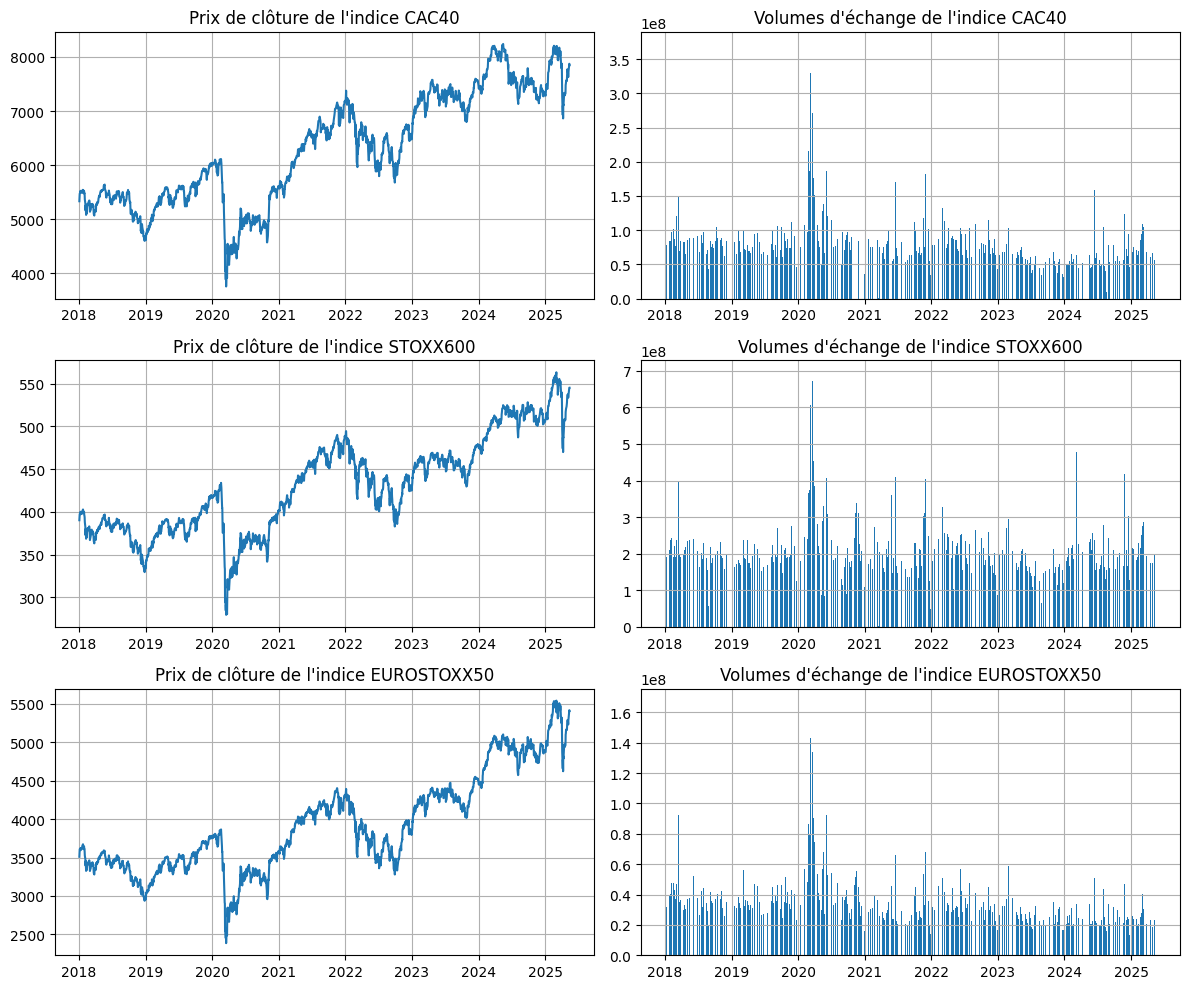

DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


In [3]:
closing_prices = ["Close_CAC40", "Close_STOXX600", "Close_EUROSTOXX50"]
volumes = ["Volume_CAC40", "Volume_STOXX600", "Volume_EUROSTOXX50"]
index = ["CAC40", "STOXX600", "EUROSTOXX50"]

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for i in range(3):
    axes[i, 0].plot(df.index, df[closing_prices[i]])
    axes[i, 0].set_title(f"Prix de clôture de l'indice {index[i]}")
    axes[i, 0].grid(True)

    axes[i, 1].bar(df.index, df[volumes[i]])
    axes[i, 1].set_title(f"Volumes d'échange de l'indice {index[i]}")
    axes[i, 1].grid(True)

    plt.tight_layout()
plt.show()
missing_dates = df[df["Volume_STOXX600"].isna()]
print(missing_dates.index)


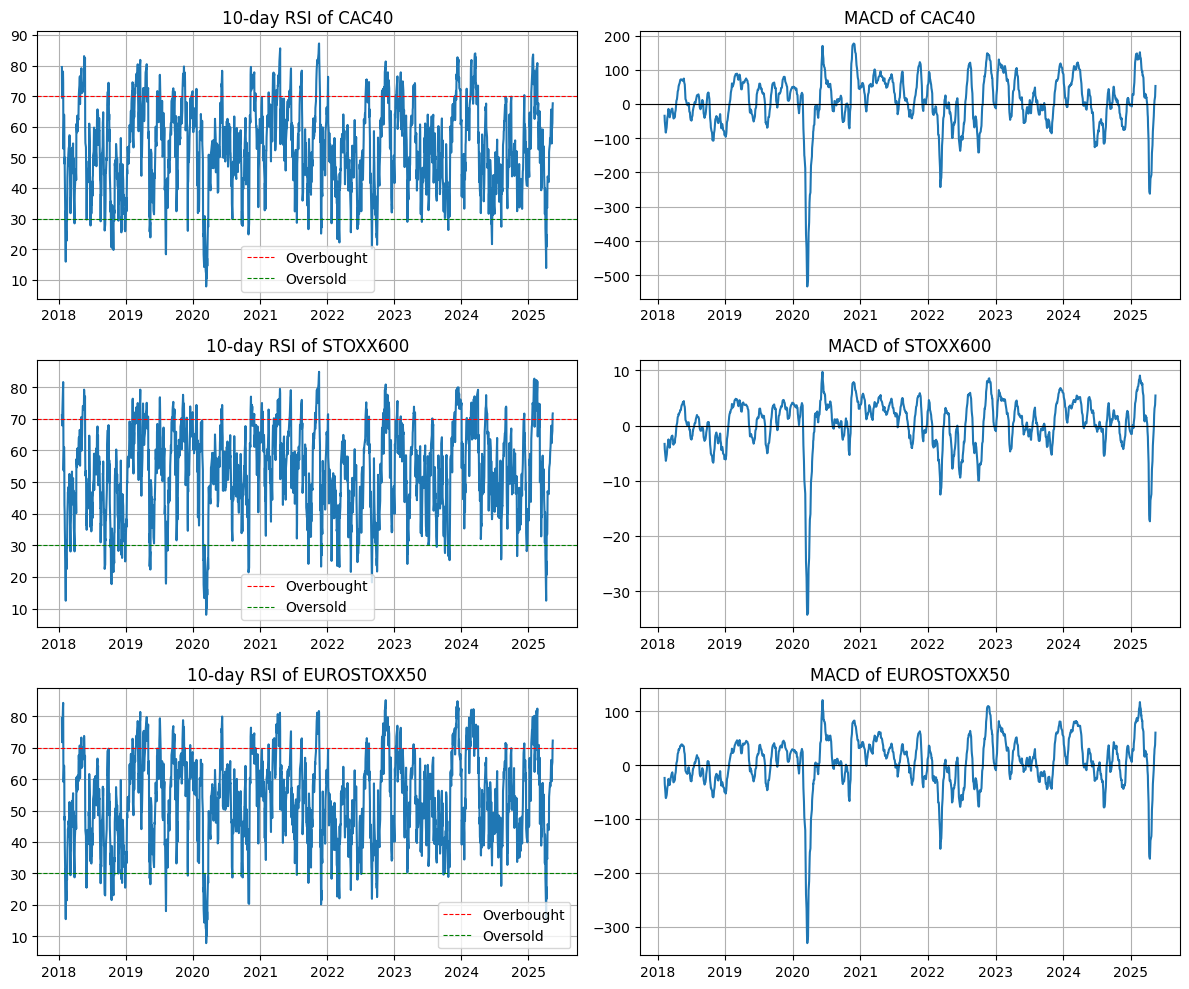

In [4]:
rsi_columns = ["RSI_10_CAC40", "RSI_10_STOXX600", "RSI_10_EUROSTOXX50"]
macd_columns = ["MACD_CAC40", "MACD_STOXX600", "MACD_EUROSTOXX50"]
index_names = ["CAC40", "STOXX600", "EUROSTOXX50"]

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

for i in range(3):
    # RSI plot
    axes[i, 0].plot(df.index, df[rsi_columns[i]])
    axes[i, 0].set_title(f"10-day RSI of {index_names[i]}")
    axes[i, 0].axhline(70, color='r', linestyle='--', linewidth=0.8, label="Overbought")
    axes[i, 0].axhline(30, color='g', linestyle='--', linewidth=0.8, label="Oversold")
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # MACD plot
    axes[i, 1].plot(df.index, df[macd_columns[i]])
    axes[i, 1].set_title(f"MACD of {index_names[i]}")
    axes[i, 1].axhline(0, color='black', linewidth=0.8)
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()


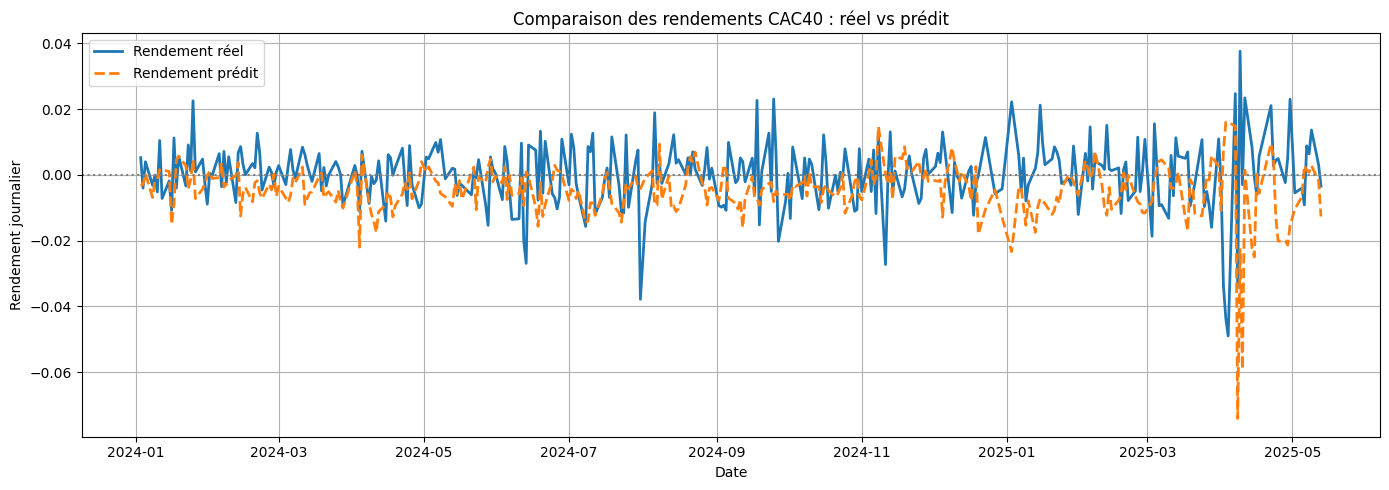

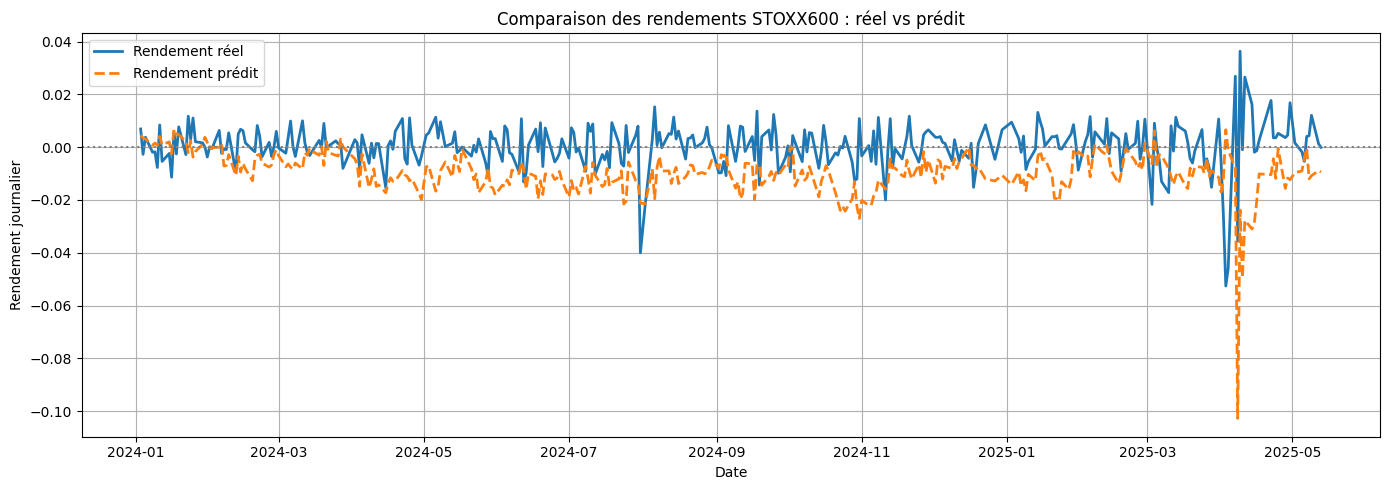

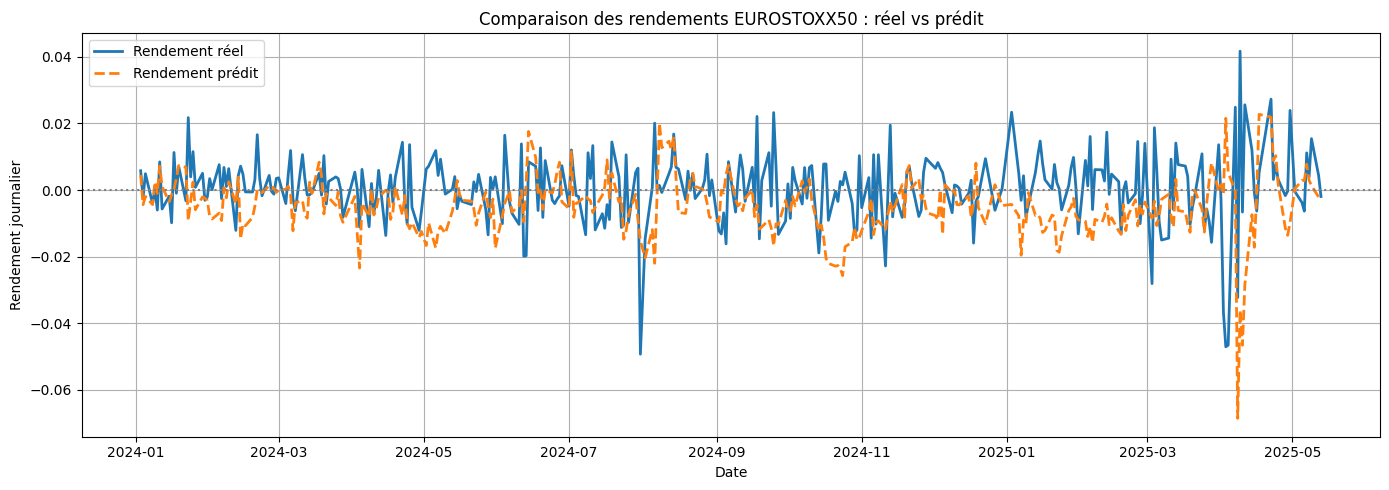

In [5]:

y_test = pd.read_parquet(PRED_DIR / "y_test_df.parquet")
y_pred_df = pd.read_parquet(PRED_DIR / "y_pred_df.parquet")


for index in ["CAC40", "STOXX600", "EUROSTOXX50"]:
    plt.figure(figsize=(14, 5))
    plt.plot(y_test.index, y_test[f"Return_{index}_t+1"], label="Rendement réel", linewidth=2)
    plt.plot(y_test.index, y_pred_df[f"Return_{index}_t+1"], label="Rendement prédit", linestyle="--", linewidth=2)
    plt.axhline(0, color="gray", linestyle=":")
    plt.title(f"Comparaison des rendements {index} : réel vs prédit")
    plt.xlabel("Date")
    plt.ylabel("Rendement journalier")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


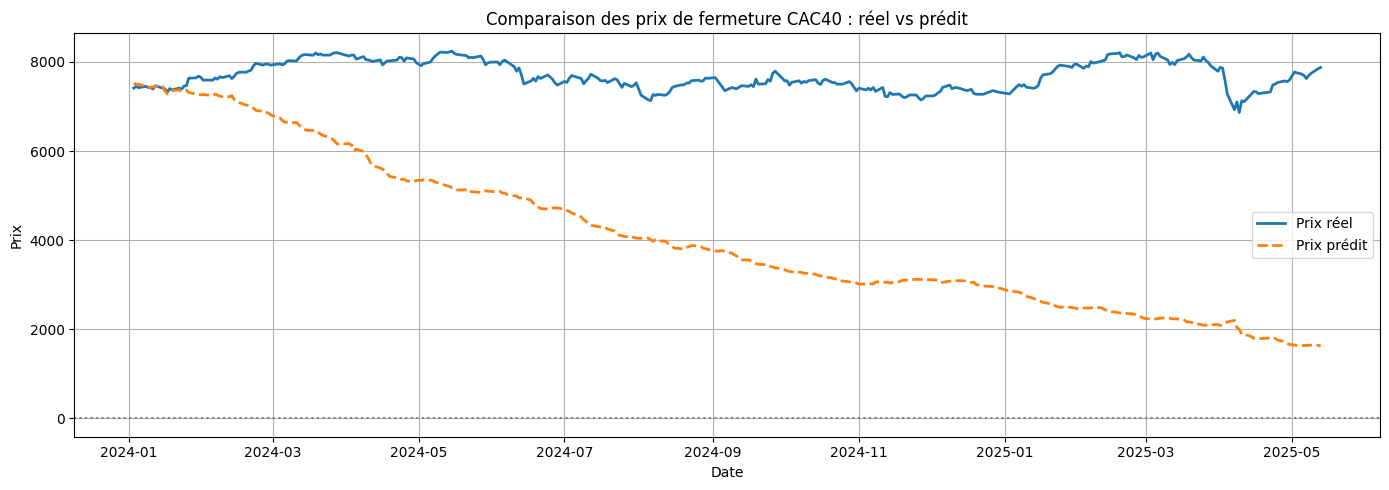

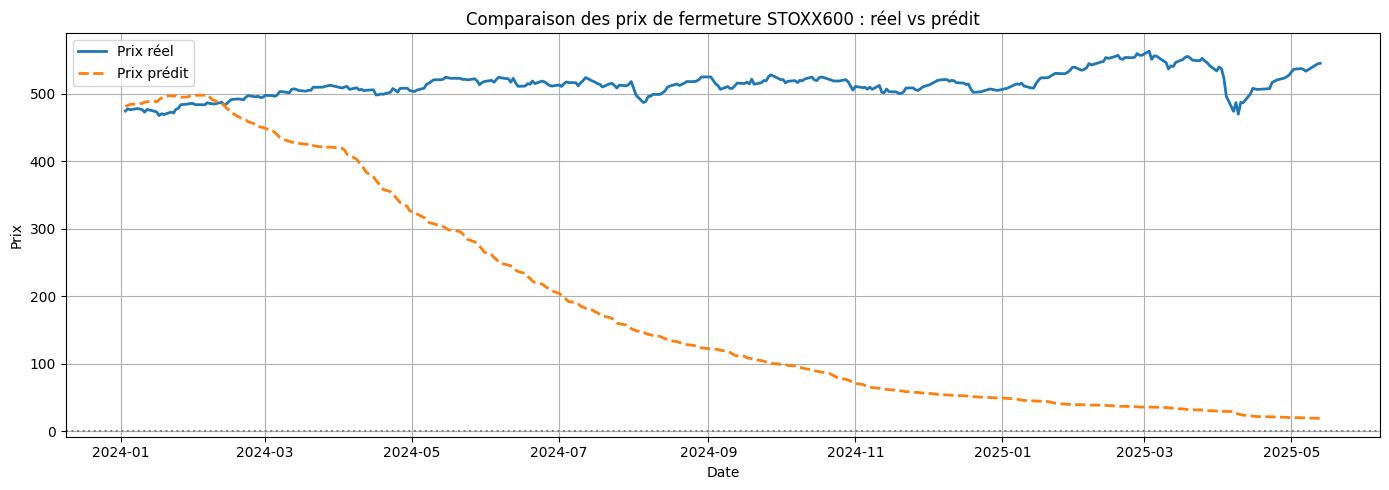

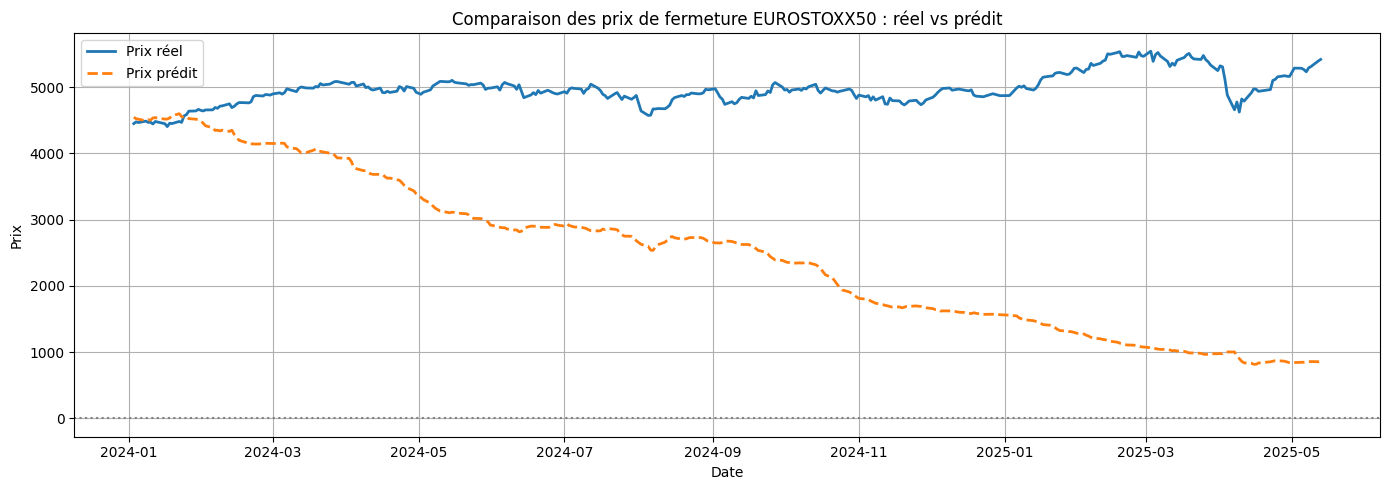

Return_CAC40_t+1  Return_STOXX600_t+1  Return_EUROSTOXX50_t+1
count        340.000000           340.000000              340.000000
mean          -0.004524            -0.009486               -0.004904
std            0.007945             0.008586                0.008838
min           -0.074062            -0.102694               -0.068528
25%           -0.007978            -0.012939               -0.009203
50%           -0.003836            -0.009023               -0.004355
75%           -0.000118            -0.004436               -0.000234
max            0.016030             0.006749                0.022739

In [6]:
y_test = pd.read_parquet(PRED_DIR / "y_test_df.parquet")
y_pred_df = pd.read_parquet(PRED_DIR / "y_pred_df.parquet")
closing_prices = pd.read_parquet(PRED_DIR / "closing_prices.parquet")
initial_price = {"CAC40" : 7543.18017578125, "STOXX600" : 479.0199890136719, "EUROSTOXX50" : 4521.64990234375}

for index in ["CAC40", "STOXX600", "EUROSTOXX50"]:
    plt.figure(figsize=(14, 5))
    plt.plot(y_test.index, closing_prices[f"Close_{index}"], label="Prix réel", linewidth=2)
    plt.plot(y_test.index, reconstruct_prices(initial_price[index], y_pred_df[f"Return_{index}_t+1"]), label="Prix prédit", linestyle="--", linewidth=2)
    plt.axhline(0, color="gray", linestyle=":")
    plt.title(f"Comparaison des prix de fermeture {index} : réel vs prédit")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
y_pred_df.describe()



## Visualisation de la corrélation des features
On considère que la corrélation entre deux variables est bénéfique (corrélation faible) que si r < 0.8

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


# Supposons que df soit ton DataFrame contenant toutes tes features
# Par exemple : df = pd.read_csv('features.csv')

# Calcul de la matrice de corrélation
#On enlève les colonnes initialement issues de yfinance, elles ont déjà été rajoutée une fois transformée en lag et en log
print(list(df.columns))

cols = ['Open', 'Close', 'High', 'Low', 'Volume']
indices = ["CAC40", "STOXX600", "EUROSTOXX50"]
col_to_drop = []

for col in cols:
    for ind in indices: 
        col_to_drop.append(f'{col}_{ind}')

col_to_drop.append("log_Close_CAC40")
col_to_drop.append("log_Close_STOXX600")
col_to_drop.append("log_Close_EUROSTOXX50")

df = df.drop(columns = col_to_drop)
print(list(df.columns))


corr_matrix = df.corr()

# Affichage de la heatmap
plt.figure(figsize=(100, 80))  # Tu peux ajuster la taille selon ton nombre de features
plt.xticks(rotation=0, fontsize=20)
plt.yticks(rotation=0, fontsize=20)
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des features')
plt.show()


['Close_CAC40', 'High_CAC40', 'Low_CAC40', 'Open_CAC40', 'Volume_CAC40', 'Close_STOXX600', 'High_STOXX600', 'Low_STOXX600', 'Open_STOXX600', 'Volume_STOXX600', 'Close_EUROSTOXX50', 'High_EUROSTOXX50', 'Low_EUROSTOXX50', 'Open_EUROSTOXX50', 'Volume_EUROSTOXX50', 'MA_5_CAC40', 'MACD_CAC40', 'EMA_10_CAC40', 'SMA_10_CAC40', 'ADX_10_CAC40', 'APO_10_CAC40', 'CCI_10_CAC40', 'MFI_10_CAC40', 'RSI_10_CAC40', 'ATR_10_CAC40', 'MA_5_EUROSTOXX50', 'MACD_EUROSTOXX50', 'EMA_10_EUROSTOXX50', 'SMA_10_EUROSTOXX50', 'ADX_10_EUROSTOXX50', 'APO_10_EUROSTOXX50', 'CCI_10_EUROSTOXX50', 'MFI_10_EUROSTOXX50', 'RSI_10_EUROSTOXX50', 'ATR_10_EUROSTOXX50', 'MA_5_STOXX600', 'MACD_STOXX600', 'EMA_10_STOXX600', 'SMA_10_STOXX600', 'ADX_10_STOXX600', 'APO_10_STOXX600', 'CCI_10_STOXX600', 'MFI_10_STOXX600', 'RSI_10_STOXX600', 'ATR_10_STOXX600', 'log_Close_CAC40', 'log_Close_CAC40_rolling_mean5', 'log_Close_CAC40_rolling_std5', 'log_Close_EUROSTOXX50', 'log_Close_EUROSTOXX50_rolling_mean5', 'log_Close_EUROSTOXX50_rolling_s

# Visualisation des prédictions sur les prix 

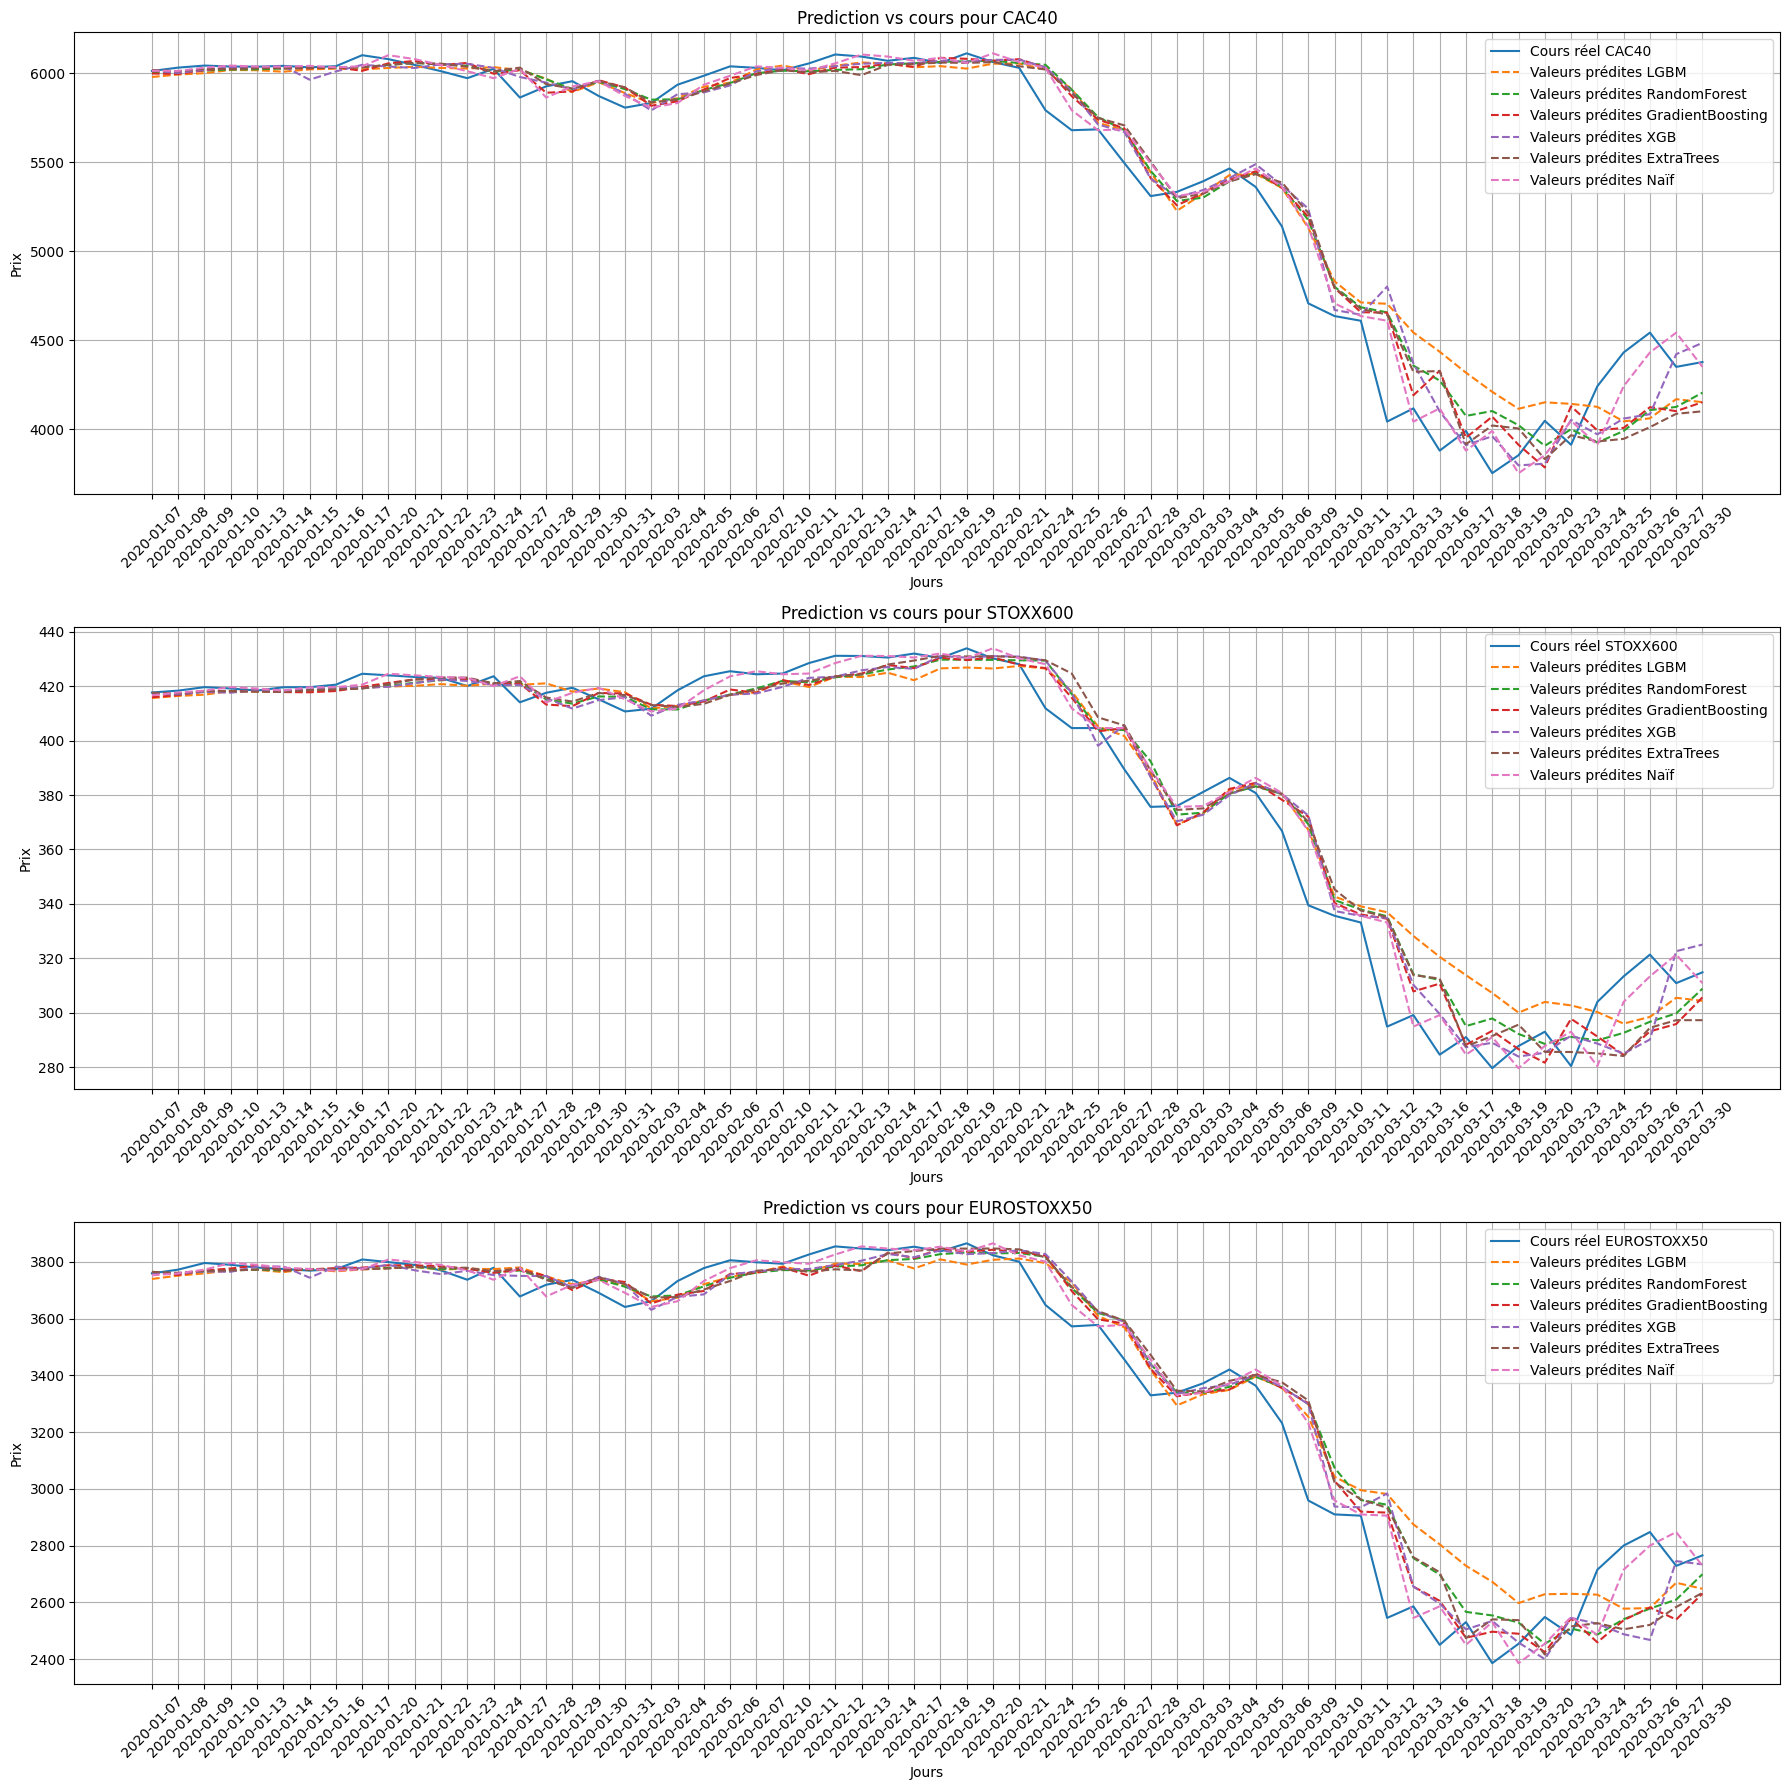

In [28]:

model_list = ['LGBM', 'RandomForest', 'GradientBoosting', 'XGB', 'ExtraTrees', 'Naïf']
predictions = {}

for model in model_list : 
    if model == 'Naïf':
        predictions[f"{model}"] = pd.read_csv(PRED_DIR / f"y_pred_Naïf.csv", index_col = 0)
    else:
        predictions[f"{model}"] = pd.read_csv(PRED_DIR / f"y_pred_{model}Regressor.csv", index_col = 0)

y_trues = pd.read_csv(PRED_DIR / "y_trues_df.csv", index_col=0)

n_outputs = 3  # 3 dans ton cas : CAC40, STOXX600, EUROSTOXX50
indices = ['CAC40', 'STOXX600', 'EUROSTOXX50']

# Tracer chaque variable cible
plt.figure(figsize=(18, 6 * n_outputs))
i=0


for ind in indices:
    plt.subplot(n_outputs, 1, i+1)
    plt.plot(y_trues.index, np.exp(y_trues[f"log_Close_{ind}"]), label=f'Cours réel {indices[i]}')

    for model, y_preds in predictions.items():
        plt.plot(y_preds.index, np.exp(y_preds[f"log_Close_{ind}"]), linestyle='--', label = f'Valeurs prédites {model}')

    plt.title(f'Prediction vs cours pour {indices[i]}')
    plt.xlabel('Jours')
    plt.xticks(rotation=45)
    plt.ylabel('Prix')
    plt.grid()
    plt.legend()
    i+=1

plt.tight_layout()
plt.show()


#### RMSE pour les prédictions sur les prix 

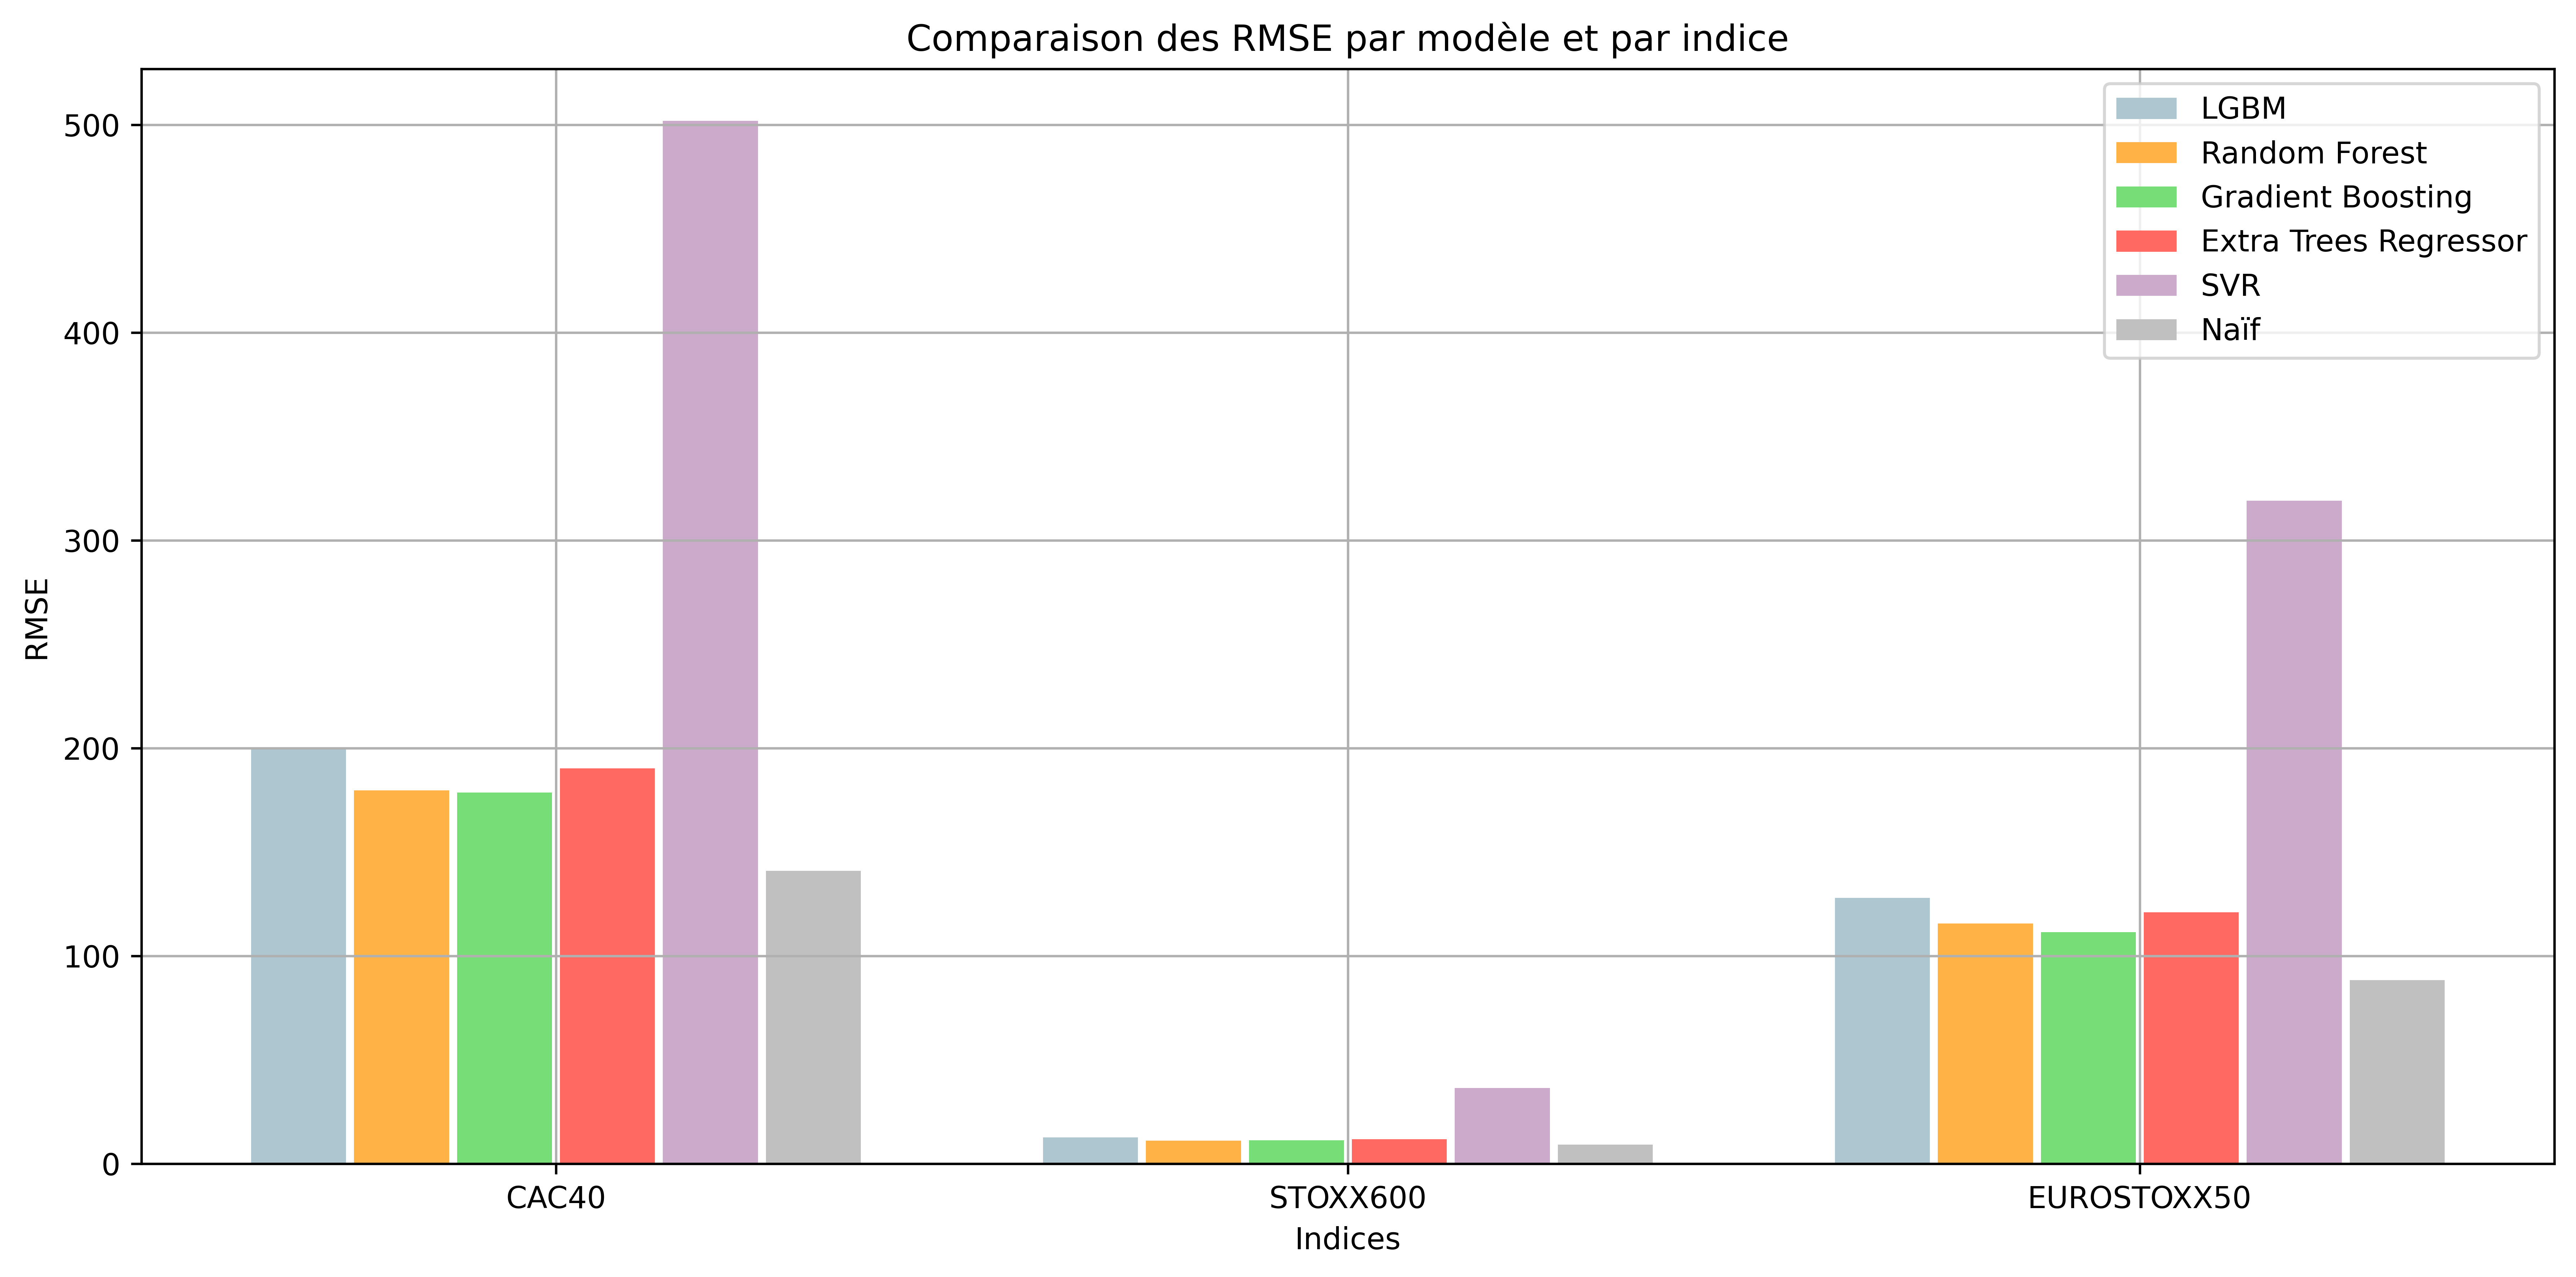

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Ton dictionnaire
RMSE = {
    'LGBM': [200.23577, 12.68836, 127.96930],
    'Random Forest': [179.66856, 11.08084, 115.73817],
    'Gradient Boosting': [178.63908, 11.38898, 111.48811],
    'Extra Trees Regressor': [190.25704, 11.87402, 121.13490],
    'SVR': [501.89003, 36.51200, 319.04107],
    'Naïf' : [140.98451, 9.18035, 88.47535]
}

# Labels
indices = ['CAC40', 'STOXX600', 'EUROSTOXX50']
models = list(RMSE.keys())
n_models = len(models)

# Couleurs pastels
pastel_colors = ['#AEC6CF', '#FFB347', '#77DD77', '#FF6961', '#CBAACB', '#C0C0C0']  # 5 couleurs pastels

# Préparation des positions
group_gap = 1  # espace entre groupes (plus grand)
bar_gap = 0.01    # petit écart entre les barres
width = 0.12     # largeur des barres

# Positions de base pour chaque groupe
group_positions = np.arange(len(indices)) * group_gap

fig, ax = plt.subplots(figsize=(12, 6), dpi = 600)

# Plot
for i, model in enumerate(models):
    # Décalage petit pour chaque barre dans le groupe
    positions = group_positions + (i - n_models/2) * (width + bar_gap) + (width + bar_gap)/2
    ax.bar(positions, RMSE[model], width=width, label=model, color=pastel_colors[i])

# Axes
ax.set_xlabel('Indices')
ax.set_ylabel('RMSE')
ax.set_title('Comparaison des RMSE par modèle et par indice')
ax.set_xticks(group_positions)
ax.set_xticklabels(indices)
ax.legend()
plt.grid()


plt.tight_layout()
plt.show()


# Visualisation des prédictions pour les log-rendements


{'CAC40': [np.float64(0.5423728813559322), np.float64(0.5254237288135594), np.float64(0.4745762711864407), np.float64(0.559322033898305), np.float64(0.4406779661016949), np.float64(0.0)], 'STOXX600': [np.float64(0.5423728813559322), np.float64(0.4576271186440678), np.float64(0.4745762711864407), np.float64(0.5084745762711864), np.float64(0.4576271186440678), np.float64(0.0)], 'EUROSTOXX50': [np.float64(0.5254237288135594), np.float64(0.5423728813559322), np.float64(0.5254237288135594), np.float64(0.559322033898305), np.float64(0.5423728813559322), np.float64(0.0)]}


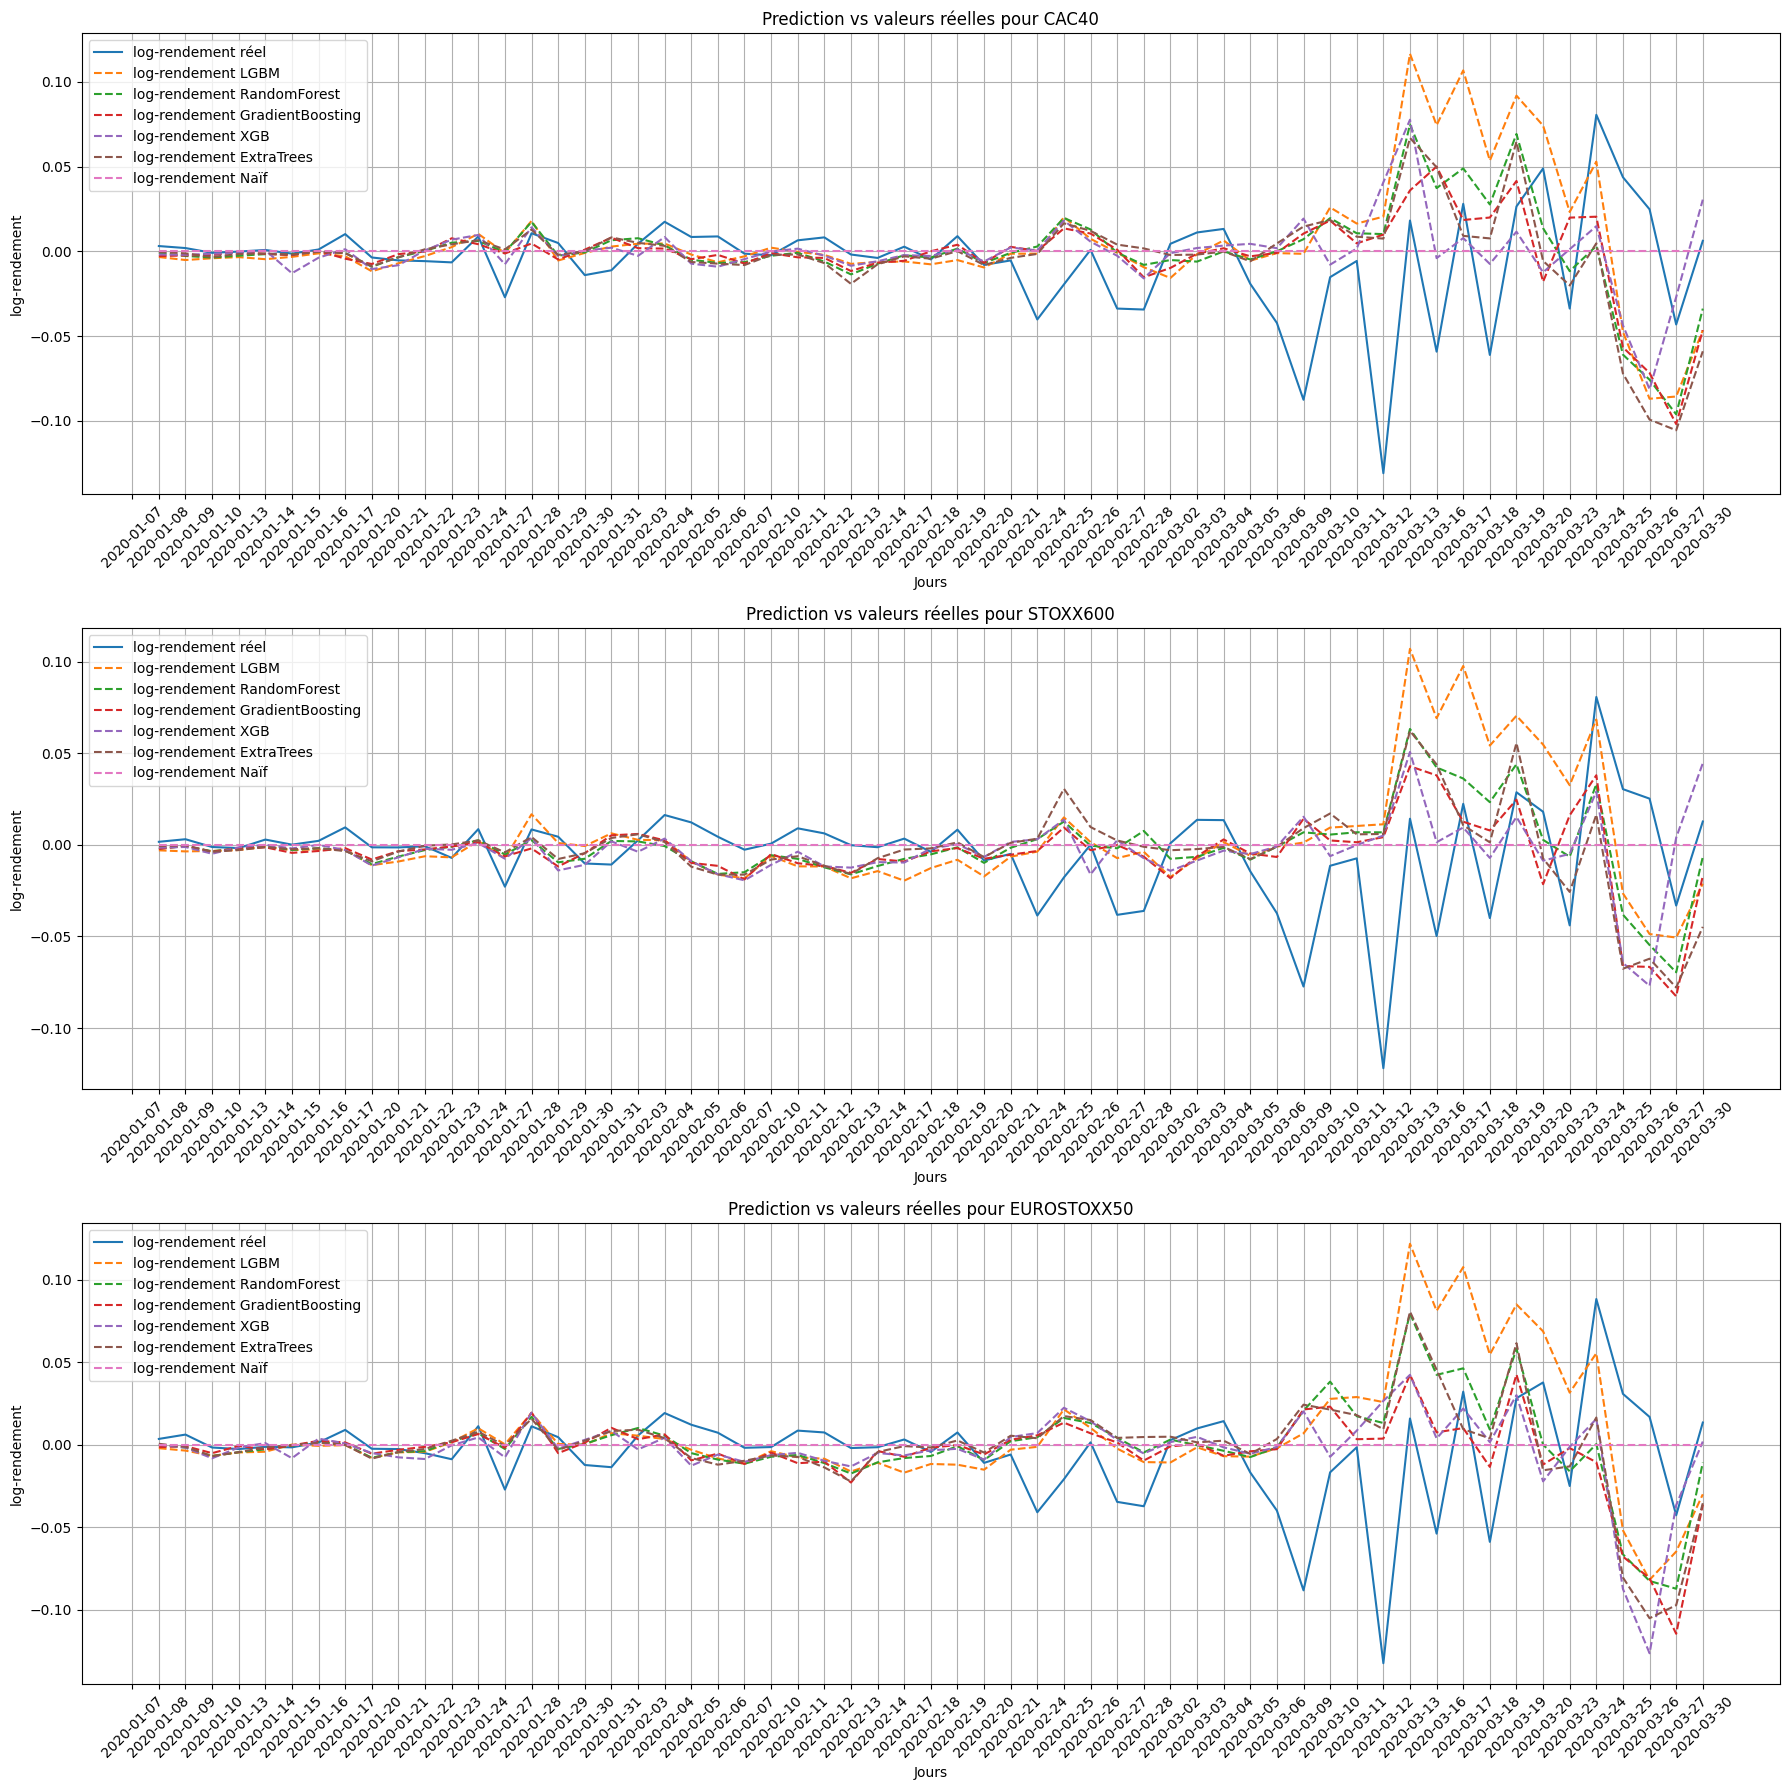

In [36]:
plt.figure(figsize=(18, 6 * n_outputs))
i=0
RMSE_return = {}
accuracy = {}


for ind in indices:
    plt.subplot(n_outputs, 1, i+1)
    log_return_real = y_trues[f"log_Close_{ind}"] - y_trues[f"log_Close_{ind}"].shift(1)
    plt.plot(y_trues.index, log_return_real, label = 'log-rendement réel')

    RMSE_return[f'{ind}'] = []
    accuracy[f'{ind}'] = []

    for model, y_preds in predictions.items():
        log_return = y_preds[f"log_Close_{ind}"] - y_trues[f"log_Close_{ind}"].shift(1)
        rmse = np.sqrt(mean_squared_error(log_return_real[1:], log_return[1:])) # Avec le décalage d'indice, la première valeur est NaN
        acc = np.mean(np.sign(log_return[1:]) == np.sign(log_return_real[1:]))
        plt.plot(log_return.index, log_return, linestyle = '--', label = f'log-rendement {model}')

        RMSE_return[f'{ind}'].append(rmse)
        accuracy[f'{ind}'].append(acc)


    plt.title(f'Prediction vs valeurs réelles pour {indices[i]}')
    plt.xlabel('Jours')
    plt.xticks(rotation=45)
    plt.ylabel('log-rendement')
    plt.tight_layout()
    plt.grid()
    plt.legend()
    i+=1

#print(RMSE_return)
print(accuracy)

#### RMSE sur les log-rendements 

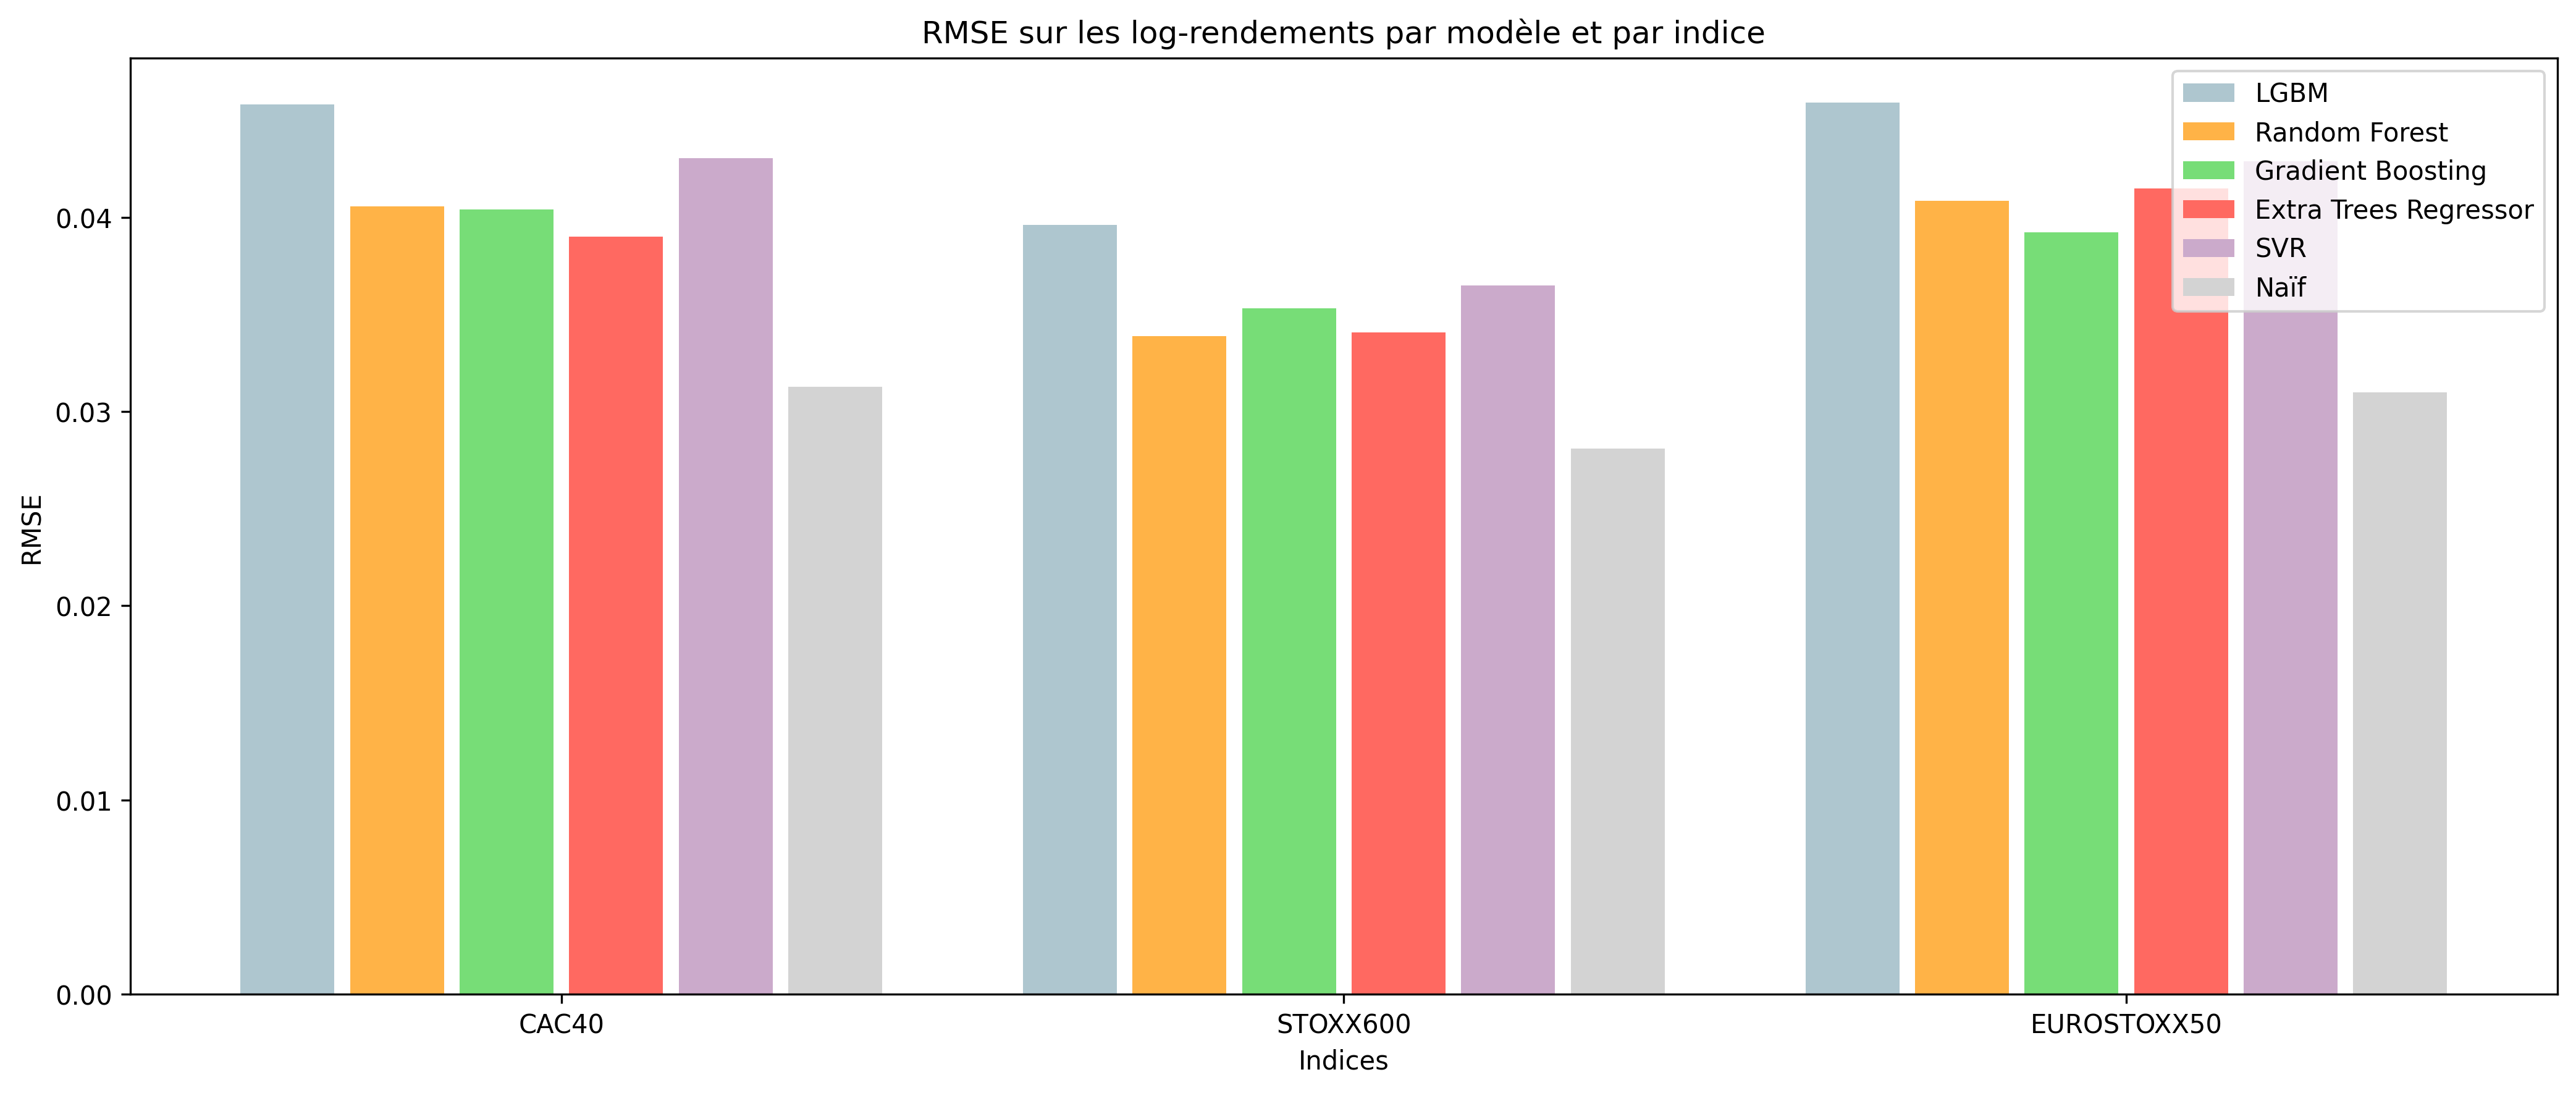

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


scores = {'CAC40': [np.float64(0.04582272265889556), np.float64(0.040557182808363644), np.float64(0.04041723873729051), np.float64(0.039013865554365486), np.float64(0.043046310224737525), np.float64(0.03128673498901453)], 'STOXX600': [np.float64(0.039602914353741525), np.float64(0.03388969508413098), np.float64(0.0353049510864745), np.float64(0.03405647371212271), np.float64(0.03650189800991342), np.float64(0.028107057006584887)], 'EUROSTOXX50': [np.float64(0.04589945947382653), np.float64(0.040842494639373526), np.float64(0.0392399695406837), np.float64(0.04148574463993824), np.float64(0.04287997727711321), np.float64(0.030980738701481016)]}

indices = list(scores.keys())
models = ["LGBM", "Random Forest", "Gradient Boosting", "Extra Trees Regressor", "SVR", "Naïf"]
n_models = len(models)


values = np.array(list(scores.values()))


x = np.arange(len(indices))
width = 0.12
pastel_colors = ['#AEC6CF', '#FFB347', '#77DD77', '#FF6961', '#CBAACB', '#D3D3D3']  # Pastel colors

fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

for i in range(n_models):
    positions = x + (i - n_models/2) * (width + 0.02) + (width + 0.02)/2
    ax.bar(positions, values[:, i], width=width, label=models[i], color=pastel_colors[i])

ax.set_xlabel('Indices')
ax.set_ylabel('RMSE')
ax.set_title('RMSE sur les log-rendements par modèle et par indice')
ax.set_xticks(x)
ax.set_xticklabels(indices)
ax.legend()

plt.tight_layout()
plt.show()


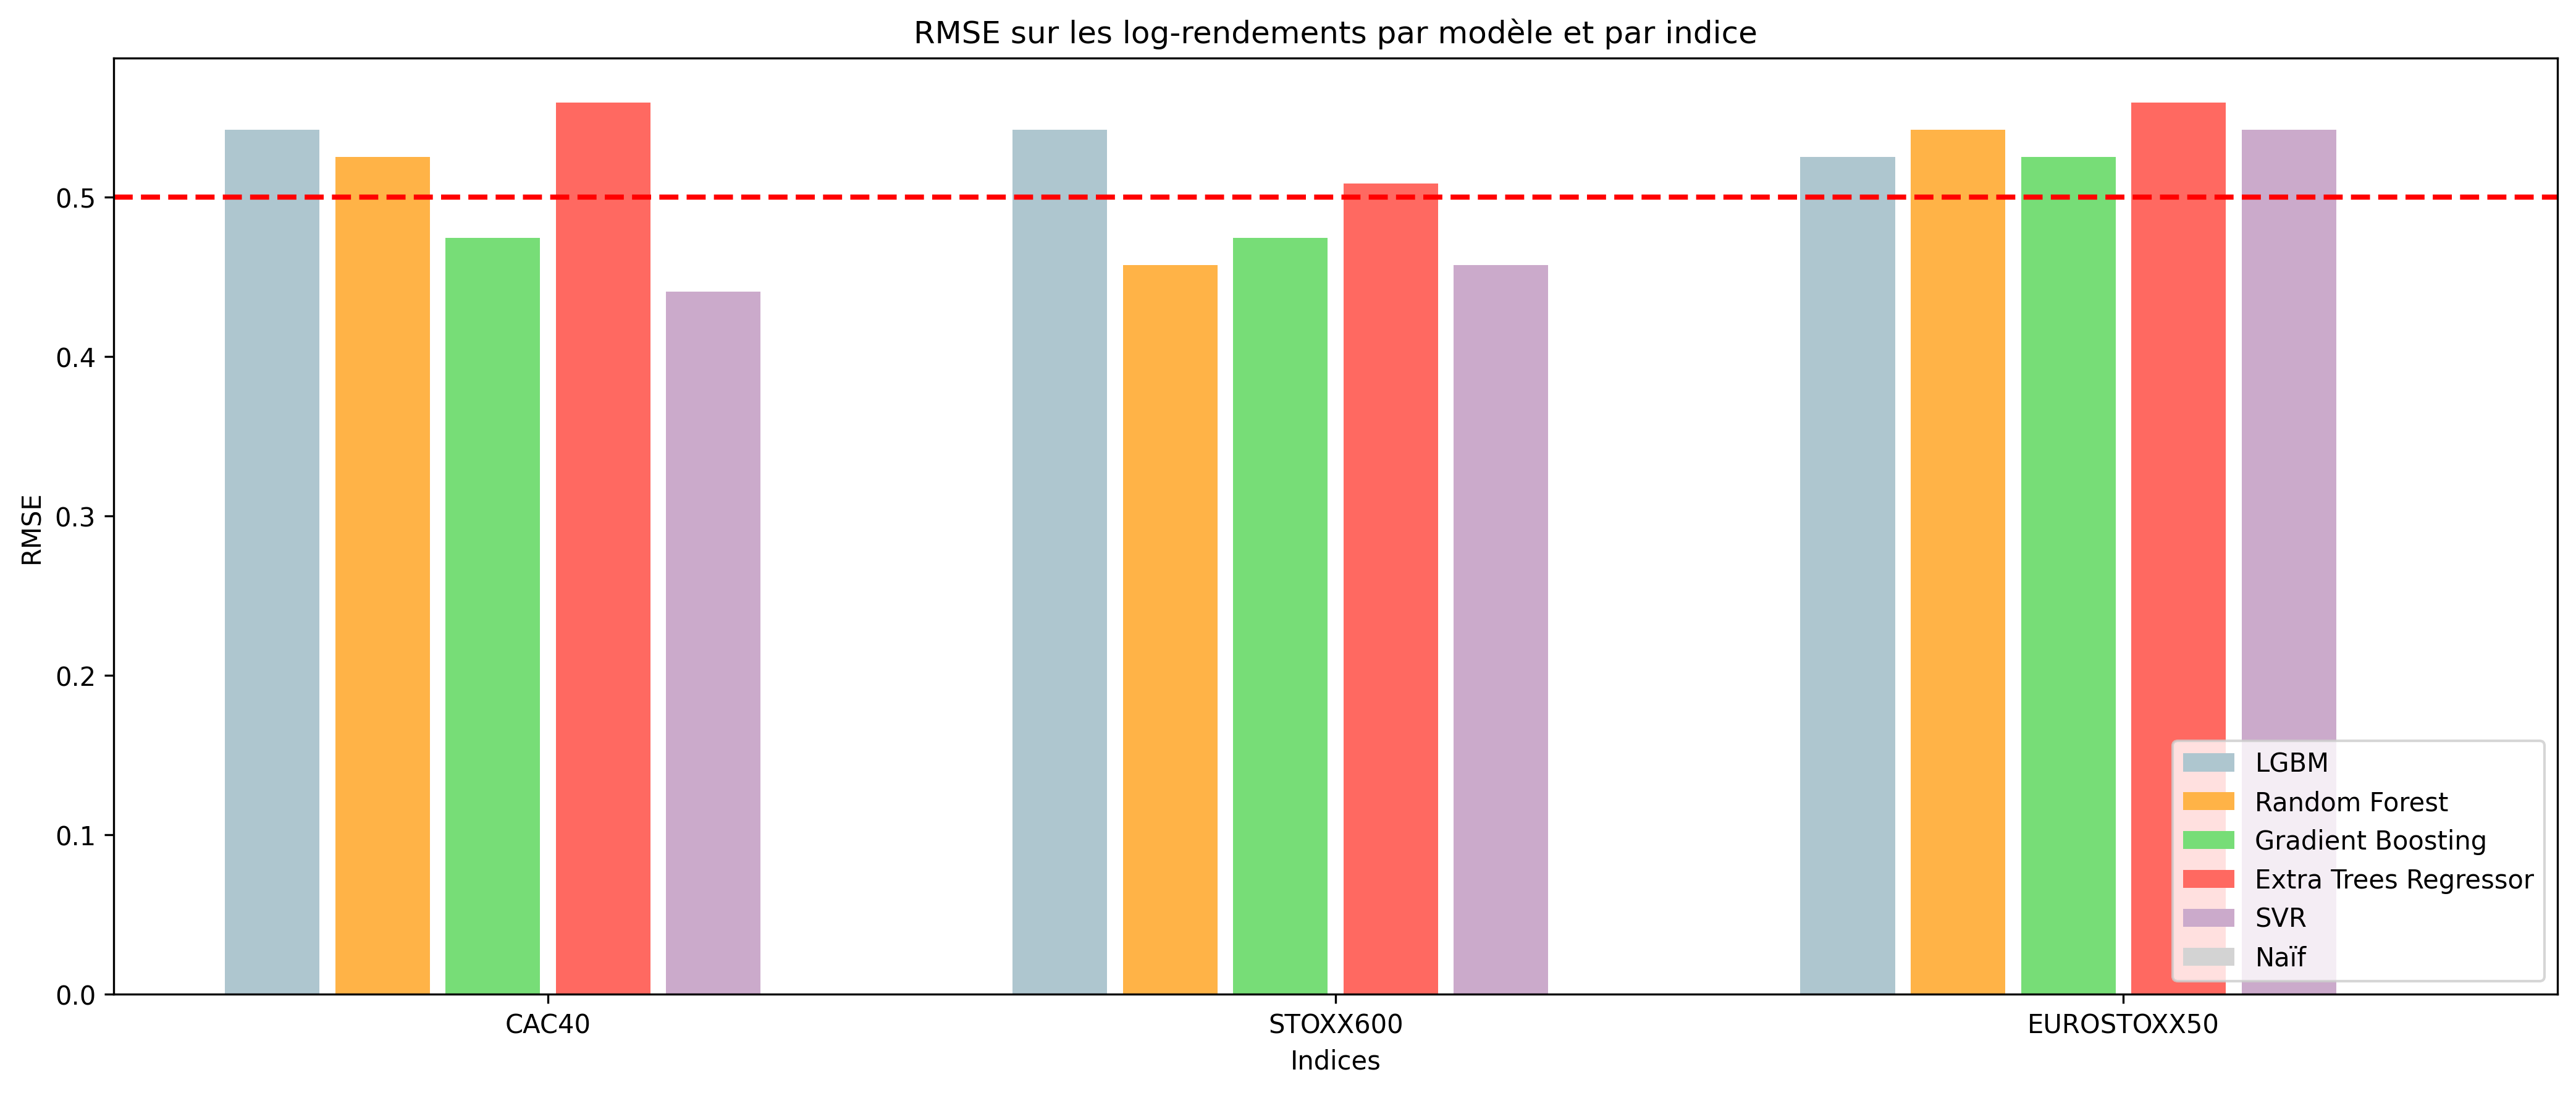

In [ ]:
scores = {'CAC40': [np.float64(0.5423728813559322), np.float64(0.5254237288135594), np.float64(0.4745762711864407), np.float64(0.559322033898305), np.float64(0.4406779661016949), np.float64(0.0)], 'STOXX600': [np.float64(0.5423728813559322), np.float64(0.4576271186440678), np.float64(0.4745762711864407), np.float64(0.5084745762711864), np.float64(0.4576271186440678), np.float64(0.0)], 'EUROSTOXX50': [np.float64(0.5254237288135594), np.float64(0.5423728813559322), np.float64(0.5254237288135594), np.float64(0.559322033898305), np.float64(0.5423728813559322), np.float64(0.0)]}

indices = list(scores.keys())
models = ["LGBM", "Random Forest", "Gradient Boosting", "Extra Trees Regressor", "SVR", "Naïf"]
n_models = len(models)


values = np.array(list(scores.values()))


x = np.arange(len(indices))
width = 0.12
pastel_colors = ['#AEC6CF', '#FFB347', '#77DD77', '#FF6961', '#CBAACB', '#D3D3D3']  # Pastel colors

fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

for i in range(n_models):
    positions = x + (i - n_models/2) * (width + 0.02) + (width + 0.02)/2
    ax.bar(positions, values[:, i], width=width, label=models[i], color=pastel_colors[i])

ax.set_xlabel('Indices')
ax.set_ylabel('RMSE')
ax.set_title('RMSE sur les log-rendements par modèle et par indice')
ax.set_xticks(x)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label = 'Seuil de rentabilité')
ax.set_xticklabels(indices)
ax.legend()

plt.tight_layout()
plt.show()


# Note méthode

Point sur les données : 

- Variables cibles : Close_CAC40(t), Close_STOXX600(t), Close_EUROSTOXX50(t)
- Supprimer pour t : Open, High, Low, Close, Volume (pas disponibles avant la clôture)
- Conserver en features : Open, High, Low, Close, Volume décalés à t-1
- Return (rendement logarithmique) : log(P_{t-1} / P_{t-2}), jamais log(P_t / P_{t-1}) pour prédire
Concrètement on prend donc les lags d'une période de Open, High, Low, Close, Volume et return
- Walk-forward validation :
    - Entraîner le modèle sur les données jusqu’à t-1
    - Prédire t
    - Ajouter les vraies valeurs de t au dataset
    - Passer à t+1 et recommencer
